<h2>Results from varying co-fed gases</h2>

In [4]:
# Some imports to stop some annoying yellow underlines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import importlib
import types
import matplotlib.ticker as mticker

# Very important lines to run the setup notebooks!!!
%run do_plot_setup.ipynb
%run do_radical_count_setup.ipynb
get_cl_radical_budget = get_cl_radical_budget # Tautology to get rid of the yellow underlines
import cl2_utilities as cl2_utils

# Extract some shared values that are used to facilitate plotting. Call 'display' on any of them to see their contents.
plot_default_properties = get_and_apply_plot_defaults() #Ignore yellow underline
line_default_properties = get_default_line_properties() #Ignore yellow underline
cl2_experiment_constants = get_cl2_experiment_constants() #Ignore yellow underline
(all_conversion_data,all_bypass_data) = get_experimental_data() #Ignore underline. These two dataframes have all the experimental results.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
# Load data for the ammonia trial
current_data = types.SimpleNamespace()

# Select data from only the the experiments we want
bypass_data = all_bypass_data[all_bypass_data["experiment_name"]=='10-03-24 Sweep NH3']
conversion_data = all_conversion_data[all_conversion_data["experiment_name"]=='10-03-24 Sweep NH3']

# Get the ammonias
ch4_conversions = conversion_data['Selected: CH4 (ppm) conversion']
cl2_conversions = conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) conversion']
start_times = conversion_data['start_time']

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
ammonias = [float(means[means.closest_start_time==t]['LF N2 MFC: Actual Flow']) for t in start_times] #Lookup the correct entry in the groupby
current_data.ammonias = [v*(100.0/200.0) for v in ammonias] # Scale appropriately
co2 = [float(means[means.closest_start_time==t]['Picarro: CO2 (ppm)']) for t in start_times]
co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]
ch2o = [float(means[means.closest_start_time==t]['FTIR: CH2O (ppm)']) for t in start_times]

# The Cl2 tank ppms are set manually here based on notes taken during each experiment; it's not recorded automatically in software.
cl2_tank_ppms = [1000]*conversion_data.shape[0]

# Extract the values and 95% CI from the CH4 conversion data
((current_data.ch4_conversions,current_data.ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)

# Extract the values and 95% CI from the Cl2 conversion data
(current_data.cl2_baseline, current_data.cl2_conversions, current_data.cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(conversion_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_absolute_accuracy_95)
# We assume a fixed Cl2 baseline and conversion equal to the no-ammonia Cl2 conversion, since the dark reaction of Cl2 and NH3 makes it impossible to measure Cl2 conversion with NH3 present
current_data.cl2_baseline = [current_data.cl2_baseline[0]]*len(current_data.cl2_baseline)
current_data.cl2_conversions = [current_data.cl2_conversions[0]]*len(current_data.cl2_conversions)
current_data.cl2_conversion_95_ci = [current_data.cl2_conversion_95_ci[0]]*len(current_data.cl2_conversion_95_ci)
current_data.inlet_cl2 = current_data.cl2_baseline

# Extract the means and 95% CI's for each gas in each bypass period
fields = ['FTIR: CO2 (ppm)','FTIR: CO (ppm)','FTIR: CH2O (ppm)']
((current_data.co2,current_data.co2_95_ci),(current_data.co,current_data.co_95_ci),(current_data.ch2o,current_data.ch2o_95_ci)) = cl2_utils.extract_spectrometer_data_from_bypass(conversion_data,bypass_data,fields,percent_accuracy_95=5,absolute_accuracy_95=1)

# Get the means and 95% CI for the sum of all of them
current_data.co_co2_ch2o_sum = current_data.co2+current_data.co+current_data.ch2o
current_data.co_co2_ch2o_95_ci = 2*np.sqrt((0.5*current_data.co2_95_ci)**2 + (0.5*current_data.co_95_ci)**2 + (0.5*current_data.ch2o_95_ci)**2)

# Compute the Cl* efficiencies
(current_data.cl_budget,current_data.cl_budget_95_ci) = get_cl_radical_budget(current_data.inlet_cl2)
current_data.cl_per_ch4 = current_data.cl_budget / current_data.ch4_conversions
current_data.cl_per_ch4_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.cl_budget,current_data.cl_budget_95_ci,current_data.ch4_conversions,current_data.ch4_95_ci)

# Save to variable and report success
ammonia_sweep_data = current_data
print("Loaded results for plotting into object 'ammonia_sweep_data'.")

Loaded results for plotting into object 'ammonia_sweep_data'.


/var/folders/p3/dkhc79qs24z8wmcfg2zy7lr00000gn/T/ipykernel_8401/823078868.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ammonias = [float(means[means.closest_start_time==t]['LF N2 MFC: Actual Flow']) for t in start_times] #Lookup the correct entry in the groupby
/var/folders/p3/dkhc79qs24z8wmcfg2zy7lr00000gn/T/ipykernel_8401/823078868.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co2 = [float(means[means.closest_start_time==t]['Picarro: CO2 (ppm)']) for t in start_times]
/var/folders/p3/dkhc79qs24z8wmcfg2zy7lr00000gn/T/ipykernel_8401/823078868.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times

In [6]:
# Load data for the toluene trial
current_data = types.SimpleNamespace()

# Select the data from the experiments we want
bypass_data = all_bypass_data[(all_bypass_data["experiment_name"]=='10-01-24 Sweep Toluene')]
conversion_data = all_conversion_data[((all_conversion_data["experiment_name"]=='10-01-24 Sweep Toluene'))]
conversion_data = conversion_data.head(5)

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
current_data.toluenes = [0,2,3,10,15]

# The Cl2 tank ppms are set manually here based on notes taken during each experiment; it's not recorded automatically in software.
cl2_tank_ppms = [1000]*conversion_data.shape[0]

# Extract the values and 95% CI from the CH4 conversion data
((current_data.ch4_conversions,current_data.ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)
#current_data.ch4_conversions[4] = 1e-12

# Extract the values and 95% CI from the Cl2 conversion data
(current_data.cl2_baseline, current_data.cl2_conversions, current_data.cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(conversion_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_absolute_accuracy_95)
# We assume a fixed Cl2 baseline and conversion equal to the no-ammonia Cl2 conversion, since the dark reaction of Cl2 and NH3 makes it impossible to measure Cl2 conversion with NH3 present
current_data.cl2_baseline = [current_data.cl2_baseline[0]]*len(current_data.cl2_baseline)
current_data.cl2_conversions = [current_data.cl2_conversions[0]]*len(current_data.cl2_conversions)
current_data.cl2_conversion_95_ci = [current_data.cl2_conversion_95_ci[0]]*len(current_data.cl2_conversion_95_ci)
current_data.inlet_cl2 = current_data.cl2_baseline

# Extract the means and 95% CI's for each gas in each bypass period
fields = ['FTIR: CO2 (ppm)','FTIR: CO (ppm)','FTIR: CH2O (ppm)']
((current_data.co2,current_data.co2_95_ci),(current_data.co,current_data.co_95_ci),(current_data.ch2o,current_data.ch2o_95_ci)) = cl2_utils.extract_spectrometer_data_from_bypass(conversion_data,bypass_data,fields,percent_accuracy_95=5,absolute_accuracy_95=1)

# Get the means and 95% CI for the sum of all of them
current_data.co_co2_ch2o_sum = current_data.co2+current_data.co+current_data.ch2o
current_data.co_co2_ch2o_95_ci = 2*np.sqrt((0.5*current_data.co2_95_ci)**2 + (0.5*current_data.co_95_ci)**2 + (0.5*current_data.ch2o_95_ci)**2)

# Compute the Cl* efficiencies
(current_data.cl_budget,current_data.cl_budget_95_ci) = get_cl_radical_budget(current_data.inlet_cl2)
current_data.cl_per_ch4 = current_data.cl_budget / current_data.ch4_conversions
current_data.cl_per_ch4_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.cl_budget,current_data.cl_budget_95_ci,current_data.ch4_conversions,current_data.ch4_95_ci)

# Save to variable and report success
toluene_sweep_data = current_data
print("Loaded results for plotting into object 'toluene_sweep_data'.")

Loaded results for plotting into object 'toluene_sweep_data'.


/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/cl2_utilities.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cl2_baseline = [(tank/flow)*float(means[means.closest_start_time==t]['Cl2 MFC: Setpoint Entry']) for t,tank,flow in zip(start_times,cl2_tank_ppm,flows)]
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/cl2_utilities.py:92: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  avg_f = np.array([float(means[means.closest_start_time==t][f]) for t in start_times]) # Average of the data points in that bypass window
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/cl2_utilities.py:93: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reading_std_f 

In [7]:
# Load data for the nitric oxide trial
current_data = types.SimpleNamespace()

# Select the data from the experiments we want
bypass_data = all_bypass_data[(all_bypass_data["experiment_name"]=='01-31-25 NO Sweep')]
conversion_data = all_conversion_data[((all_conversion_data["experiment_name"]=='01-31-25 NO Sweep'))]

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
current_data.nitric_oxides = [0.5, 1, 2, 7.5, 15]

# The Cl2 tank ppms are set manually here based on notes taken during each experiment; it's not recorded automatically in software.
cl2_tank_ppms = [1000]*conversion_data.shape[0]

# Extract the values and 95% CI from the CH4 conversion data
((current_data.ch4_conversions,current_data.ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)
#current_data.ch4_conversions[4] = 1e-12

# Extract the values and 95% CI from the Cl2 conversion data
(current_data.cl2_baseline, current_data.cl2_conversions, current_data.cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(conversion_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_absolute_accuracy_95)
current_data.cl2_conversions = [current_data.cl2_conversions[0]]*len(current_data.cl2_conversions)
current_data.cl2_conversion_95_ci = [current_data.cl2_conversion_95_ci[0]]*len(current_data.cl2_conversion_95_ci)
current_data.inlet_cl2 = current_data.cl2_baseline

# Extract the means and 95% CI's for each gas in each bypass period
fields = ['FTIR: CO2 (ppm)','FTIR: CO (ppm)','FTIR: CH2O (ppm)']
((current_data.co2,current_data.co2_95_ci),(current_data.co,current_data.co_95_ci),(current_data.ch2o,current_data.ch2o_95_ci)) = cl2_utils.extract_spectrometer_data_from_bypass(conversion_data,bypass_data,fields,percent_accuracy_95=5,absolute_accuracy_95=1)

# Get the means and 95% CI for the sum of all of them
current_data.co_co2_ch2o_sum = current_data.co2+current_data.co+current_data.ch2o
current_data.co_co2_ch2o_95_ci = 2*np.sqrt((0.5*current_data.co2_95_ci)**2 + (0.5*current_data.co_95_ci)**2 + (0.5*current_data.ch2o_95_ci)**2)

# Compute the Cl* efficiencies
(current_data.cl_budget,current_data.cl_budget_95_ci) = get_cl_radical_budget(current_data.inlet_cl2)
current_data.cl_per_ch4 = current_data.cl_budget / current_data.ch4_conversions
current_data.cl_per_ch4_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.cl_budget,current_data.cl_budget_95_ci,current_data.ch4_conversions,current_data.ch4_95_ci)

# Save to variable and report success
nitric_oxide_sweep_data = current_data
print("Loaded results for plotting into object 'nitric_oxide_sweep_data'.")

Loaded results for plotting into object 'nitric_oxide_sweep_data'.


/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/cl2_utilities.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cl2_baseline = [(tank/flow)*float(means[means.closest_start_time==t]['Cl2 MFC: Setpoint Entry']) for t,tank,flow in zip(start_times,cl2_tank_ppm,flows)]
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/cl2_utilities.py:92: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  avg_f = np.array([float(means[means.closest_start_time==t][f]) for t in start_times]) # Average of the data points in that bypass window
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/cl2_utilities.py:93: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reading_std_f 

In [8]:
# Load data for the ammonia trial
current_data = types.SimpleNamespace()

# Select data from only the the experiments we want
bypass_data = all_bypass_data[all_bypass_data["experiment_name"]=='02-07-25 H2S Sweep']
conversion_data = all_conversion_data[all_conversion_data["experiment_name"]=='02-07-25 H2S Sweep']

# Get the ammonias
ch4_conversions = conversion_data['Selected: CH4 (ppm) conversion']
cl2_conversions = conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) conversion']
start_times = conversion_data['start_time']

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
hydrogen_sulfides = [float(means[means.closest_start_time==t]['LF N2 MFC: Actual Flow']) for t in start_times] #Lookup the correct entry in the groupby
current_data.hydrogen_sulfides = [v*(50.0/200.0) for v in hydrogen_sulfides] # Scale appropriately
co2 = [float(means[means.closest_start_time==t]['Picarro: CO2 (ppm)']) for t in start_times]
co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]
ch2o = [float(means[means.closest_start_time==t]['FTIR: CH2O (ppm)']) for t in start_times]

# The Cl2 tank ppms are set manually here based on notes taken during each experiment; it's not recorded automatically in software.
cl2_tank_ppms = [1000]*conversion_data.shape[0]

# Extract the values and 95% CI from the CH4 conversion data
((current_data.ch4_conversions,current_data.ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)

# Extract the values and 95% CI from the Cl2 conversion data
(current_data.cl2_baseline, current_data.cl2_conversions, current_data.cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(conversion_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_absolute_accuracy_95)
# We assume a fixed Cl2 baseline and conversion equal to the no-ammonia Cl2 conversion, since the dark reaction of Cl2 and NH3 makes it impossible to measure Cl2 conversion with NH3 present
current_data.cl2_baseline = [current_data.cl2_baseline[0]]*len(current_data.cl2_baseline)
current_data.cl2_conversions = [current_data.cl2_conversions[0]]*len(current_data.cl2_conversions)
current_data.cl2_conversion_95_ci = [current_data.cl2_conversion_95_ci[0]]*len(current_data.cl2_conversion_95_ci)
current_data.inlet_cl2 = current_data.cl2_baseline

# Extract the means and 95% CI's for each gas in each bypass period
fields = ['FTIR: CO2 (ppm)','FTIR: CO (ppm)','FTIR: CH2O (ppm)']
((current_data.co2,current_data.co2_95_ci),(current_data.co,current_data.co_95_ci),(current_data.ch2o,current_data.ch2o_95_ci)) = cl2_utils.extract_spectrometer_data_from_bypass(conversion_data,bypass_data,fields,percent_accuracy_95=5,absolute_accuracy_95=1)

# Get the means and 95% CI for the sum of all of them
current_data.co_co2_ch2o_sum = current_data.co2+current_data.co+current_data.ch2o
current_data.co_co2_ch2o_95_ci = 2*np.sqrt((0.5*current_data.co2_95_ci)**2 + (0.5*current_data.co_95_ci)**2 + (0.5*current_data.ch2o_95_ci)**2)

# Compute the Cl* efficiencies
(current_data.cl_budget,current_data.cl_budget_95_ci) = get_cl_radical_budget(current_data.inlet_cl2)
current_data.cl_per_ch4 = current_data.cl_budget / current_data.ch4_conversions
current_data.cl_per_ch4_95_ci = cl2_utils.get_95_ci_of_ratio(current_data.cl_budget,current_data.cl_budget_95_ci,current_data.ch4_conversions,current_data.ch4_95_ci)

# Save to variable and report success
hydrogen_sulfide_sweep_data = current_data
print("Loaded results for plotting into object 'hydrogen_sulfide_sweep_data'.")

Loaded results for plotting into object 'hydrogen_sulfide_sweep_data'.


/var/folders/p3/dkhc79qs24z8wmcfg2zy7lr00000gn/T/ipykernel_8401/1036955354.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hydrogen_sulfides = [float(means[means.closest_start_time==t]['LF N2 MFC: Actual Flow']) for t in start_times] #Lookup the correct entry in the groupby
/var/folders/p3/dkhc79qs24z8wmcfg2zy7lr00000gn/T/ipykernel_8401/1036955354.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co2 = [float(means[means.closest_start_time==t]['Picarro: CO2 (ppm)']) for t in start_times]
/var/folders/p3/dkhc79qs24z8wmcfg2zy7lr00000gn/T/ipykernel_8401/1036955354.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in

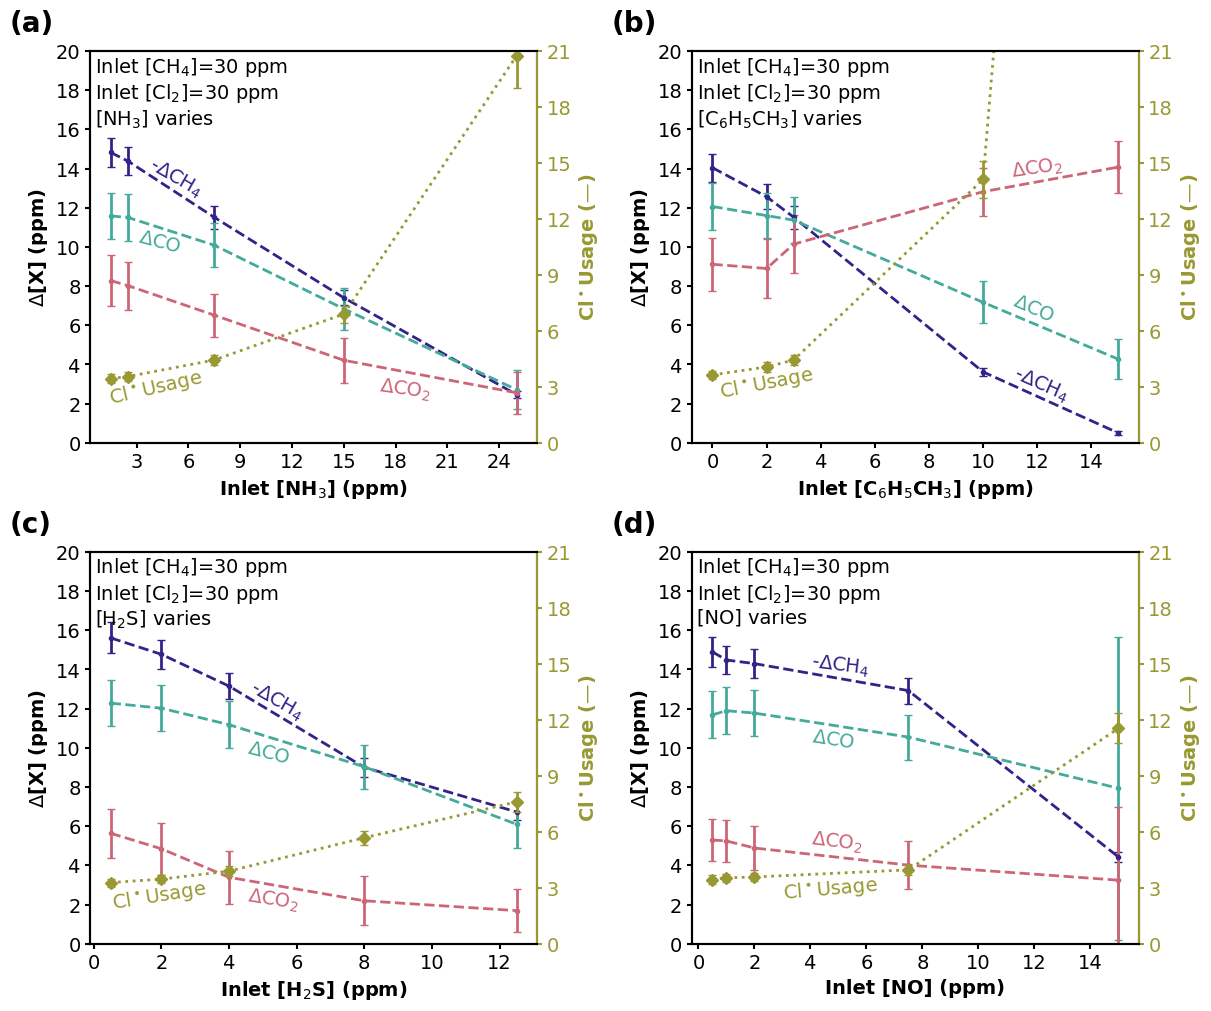

In [9]:
# Global settings
use_error_bars = True

# Set up axes
(fig,(((ax_a,ax_b),(ax_c,ax_d))))=plt.subplots(2,2,figsize=(plot_default_properties['figure_width'],10))
ax_a.text(-0.18,1.05, "(a)", transform=ax_a.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')
ax_a_right = ax_a.twinx()
ax_b.text(-0.18,1.05, "(b)", transform=ax_b.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')
ax_b_right = ax_b.twinx()
ax_c.text(-0.18,1.05, "(c)", transform=ax_c.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')
ax_c_right = ax_c.twinx()
ax_d.text(-0.18,1.05, "(d)", transform=ax_d.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')
ax_d_right = ax_d.twinx()

# Plot the lines and set the axis labels, the same for all axes
for (current_data, current_axis, current_axis_right,x_vals) in zip((ammonia_sweep_data,toluene_sweep_data,hydrogen_sulfide_sweep_data,nitric_oxide_sweep_data),
                                                                   (ax_a,ax_b,ax_c,ax_d),(ax_a_right,ax_b_right,ax_c_right,ax_d_right),
                                                                   (ammonia_sweep_data.ammonias,toluene_sweep_data.toluenes,hydrogen_sulfide_sweep_data.hydrogen_sulfides,nitric_oxide_sweep_data.nitric_oxides)):

    if current_data is not None:
        cl2_utils.do_error_bar(current_axis,line_default_properties,'CH4',x_vals,current_data.ch4_conversions,(current_data.ch4_95_ci if use_error_bars else None))
        #cl2_utils.do_error_bar(current_axis,line_default_properties,'Cl2',x_vals,current_data.cl2_conversions,(current_data.cl2_conversion_95_ci if use_error_bars else None))
        cl2_utils.do_error_bar(current_axis,line_default_properties,'CO',x_vals,current_data.co,(current_data.co_95_ci if use_error_bars else None))
        cl2_utils.do_error_bar(current_axis,line_default_properties,'CO2',x_vals,current_data.co2,(current_data.co2_95_ci if use_error_bars else None))
        #cl2_utils.do_error_bar(current_axis,line_default_properties,'CH2O',x_vals,current_data.ch2o,(current_data.ch2o_95_ci if use_error_bars else None))
        #cl2_utils.do_error_bar(current_axis,line_default_properties,'C1 Sum',x_vals,current_data.co_co2_ch2o_sum,(current_data.co_co2_ch2o_95_ci if use_error_bars else None))
        cl2_utils.do_error_bar(current_axis_right,line_default_properties,'Cl* Efficiency',x_vals,current_data.cl_per_ch4,(current_data.cl_per_ch4_95_ci if use_error_bars else None))

    current_axis.set_ylabel("$\Delta$[X] (ppm)",fontweight=plot_default_properties['font_weight'])
    current_axis.xaxis.set_tick_params(labelbottom=True)
    current_axis_right.set_ylabel(line_default_properties['Cl* Efficiency']['text']+" (—)",fontweight=plot_default_properties['font_weight'])
    current_axis_right.xaxis.set_tick_params(labelbottom=True)
    right_ax_color = line_default_properties['Cl* Efficiency']['color']
    current_axis_right.tick_params(axis='y', colors=right_ax_color)
    current_axis_right.yaxis.label.set_color(right_ax_color)
    current_axis_right.spines['right'].set_color(right_ax_color)
    current_axis_right.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    current_axis.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    current_axis.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    #current_axis.set_xlim(left=-0.5)
    

# Manually set axis limits and labels where needed
ax_a.set_ylim(0,20)
ax_b.set_ylim(0,20)
ax_c.set_ylim(0,20)
ax_d.set_ylim(0,20)
ax_a_right.set_ylim(0,21)
ax_b_right.set_ylim(0,21)
ax_c_right.set_ylim(0,21)
ax_d_right.set_ylim(0,21)
ax_a.set_xlabel("Inlet [NH$_3$] (ppm)",fontweight=plot_default_properties['font_weight'])
ax_b.set_xlabel("Inlet [C$_6$H$_5$CH$_3$] (ppm)",fontweight=plot_default_properties['font_weight'])
ax_c.set_xlabel("Inlet [H$_2$S] (ppm)",fontweight=plot_default_properties['font_weight'])
ax_d.set_xlabel("Inlet [NO] (ppm)",fontweight=plot_default_properties['font_weight'])

# Label the lines
labels_a = (('CH4',3.5,12.3,-30),
          ('CO2',17,2,-8),
          ('CO',3,9.5,-15),
          ('Cl* Efficiency',1.3,1.7,13))
cl2_utils.label_lines(ax_a,line_default_properties,labels_a)
ax_a.text(0.01,0.99,"Inlet [CH$_4$]=30 ppm\nInlet [Cl$_2$]=30 ppm\n[NH$_3$] varies",transform=ax_a.transAxes,ha='left',va='top')

labels_b = (('CH4',11,1.9,-24),
          ('CO2',11,13.3,8),
          ('CO',11,6,-24),
          ('Cl* Efficiency',0.2,2,11))
cl2_utils.label_lines(ax_b,line_default_properties,labels_b)
ax_b.text(0.01,0.99,"Inlet [CH$_4$]=30 ppm\nInlet [Cl$_2$]=30 ppm\n[C$_6$H$_5$CH$_3$] varies",transform=ax_b.transAxes,ha='left',va='top')

labels_c = (('CH4',4.5,11.2,-30),
          ('CO2',4.5,1.5,-9),
          ('CO',4.5,9,-15),
          ('Cl* Efficiency',0.5,1.5,9))
cl2_utils.label_lines(ax_c,line_default_properties,labels_c)
ax_c.text(0.01,0.99,"Inlet [CH$_4$]=30 ppm\nInlet [Cl$_2$]=30 ppm\n[H$_2$S] varies",transform=ax_c.transAxes,ha='left',va='top')

labels_d = (('CH4',4,13.5,-7),
          ('CO2',4,4.5,-7),
          ('CO',4,9.8,-9),
          ('Cl* Efficiency',3,2,5))
cl2_utils.label_lines(ax_d,line_default_properties,labels_d)
ax_d.text(0.01,0.99,"Inlet [CH$_4$]=30 ppm\nInlet [Cl$_2$]=30 ppm\n[NO] varies",transform=ax_d.transAxes,ha='left',va='top')

for ax in [ax_a, ax_a_right, ax_b, ax_b_right, ax_c, ax_c_right, ax_d, ax_d_right]:
    ax.tick_params(width=plot_default_properties['box_linewidth'])
    for spine in ax.spines.values():
        spine.set_linewidth(plot_default_properties['box_linewidth'])   

plt.savefig('exported_images/vary_co_fed_gases_results.png', bbox_inches='tight',dpi=300)
plt.show()